In [1]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 다운로드
df = yf.download('000660.KS', start='2020-01-01', end='2025-06-30')[['Close']].reset_index()
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])

train = df[df['ds'] <= '2024-12-31'].copy()
test = df[df['ds'] >= '2025-01-01'].copy()

# 추세 변화 민감도: 클수록 추세 변화를 더 민감하게 감지 (과적합 위험 증가)
changepoint_prior_scales = [0.001, 0.01, 0.1]

# 계절성 민감도: 클수록 더 복잡한 계절성 패턴을 허용
seasonality_prior_scales = [1.0, 10.0]

# 계절성 모드:
# 'additive' → y에 일정량 더해지는 형태 (ex. 매년 비슷한 금액의 변화)
# 'multiplicative' → y의 크기에 비례해 변화 (ex. 매출이 커질수록 더 큰 계절성 진폭)
seasonality_modes = ['additive', 'multiplicative']

# 추세 변화점이 전체 학습 구간 중 앞쪽 몇 %에 포함될지 결정
# 0.8 → 처음 80%에만 변화점 배치
changepoint_ranges = [0.8, 0.9]

# 모델이 허용하는 추세 변화점 개수
n_changepoints_list = [10, 25, 50]

# 연간 계절성 반영 여부
yearly_opts = [True, False]

# 주간 계절성 반영 여부
weekly_opts = [True, False]

# 일간 계절성 반영 여부
daily_opts = [True, False]



param_combinations = itertools.product(
    changepoint_prior_scales,
    seasonality_prior_scales,
    seasonality_modes,
    changepoint_ranges,
    n_changepoints_list,
    yearly_opts,
    weekly_opts,
    daily_opts
)


results = []

for cps, sps, mode, cpr, n_cp, yearly, weekly, daily in param_combinations:
    try:
        model = Prophet(
            changepoint_prior_scale=cps,
            seasonality_prior_scale=sps,
            seasonality_mode=mode,
            changepoint_range=cpr,
            n_changepoints=n_cp,
            yearly_seasonality=yearly,
            weekly_seasonality=weekly,
            daily_seasonality=daily)
        
        model.fit(train)
        future = pd.DataFrame({'ds': pd.date_range(start=df['ds'].min(), end= test['ds'].max())})
        forecast = model.predict(future)

        pred = forecast[['ds', 'yhat']].set_index('ds')
        merged = test.set_index('ds').join(pred, how='left')
        
        mae = mean_absolute_error(merged['y'], merged['yhat'])
        results.append({
                        'changepoint_prior_scale': cps,
                        'seasonality_prior_scale': sps,
                        'seasonality_mode': mode,
                        'changepoint_range': cpr,
                        'n_changepoints': n_cp,
                        'yearly': yearly,
                        'weekly': weekly,
                        'daily': daily,
                        'MAE': mae
                    })
    except Exception as e:
        print(e)



[*********************100%***********************]  1 of 1 completed
08:22:49 - cmdstanpy - INFO - Chain [1] start processing
08:22:49 - cmdstanpy - INFO - Chain [1] done processing
08:22:49 - cmdstanpy - INFO - Chain [1] start processing
08:22:49 - cmdstanpy - INFO - Chain [1] done processing
08:22:50 - cmdstanpy - INFO - Chain [1] start processing
08:22:50 - cmdstanpy - INFO - Chain [1] done processing
08:22:50 - cmdstanpy - INFO - Chain [1] start processing
08:22:50 - cmdstanpy - INFO - Chain [1] done processing
08:22:50 - cmdstanpy - INFO - Chain [1] start processing
08:22:50 - cmdstanpy - INFO - Chain [1] done processing
08:22:51 - cmdstanpy - INFO - Chain [1] start processing
08:22:51 - cmdstanpy - INFO - Chain [1] done processing
08:22:51 - cmdstanpy - INFO - Chain [1] start processing
08:22:51 - cmdstanpy - INFO - Chain [1] done processing
08:22:51 - cmdstanpy - INFO - Chain [1] start processing
08:22:51 - cmdstanpy - INFO - Chain [1] done processing
08:22:52 - cmdstanpy - INFO

08:30:57 - cmdstanpy - INFO - Chain [1] start processing


   changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                      0.1                     10.0   multiplicative   

   changepoint_range  n_changepoints  yearly  weekly  daily           MAE  
0                0.8              50   False   False   True  16502.799881  


08:30:58 - cmdstanpy - INFO - Chain [1] done processing


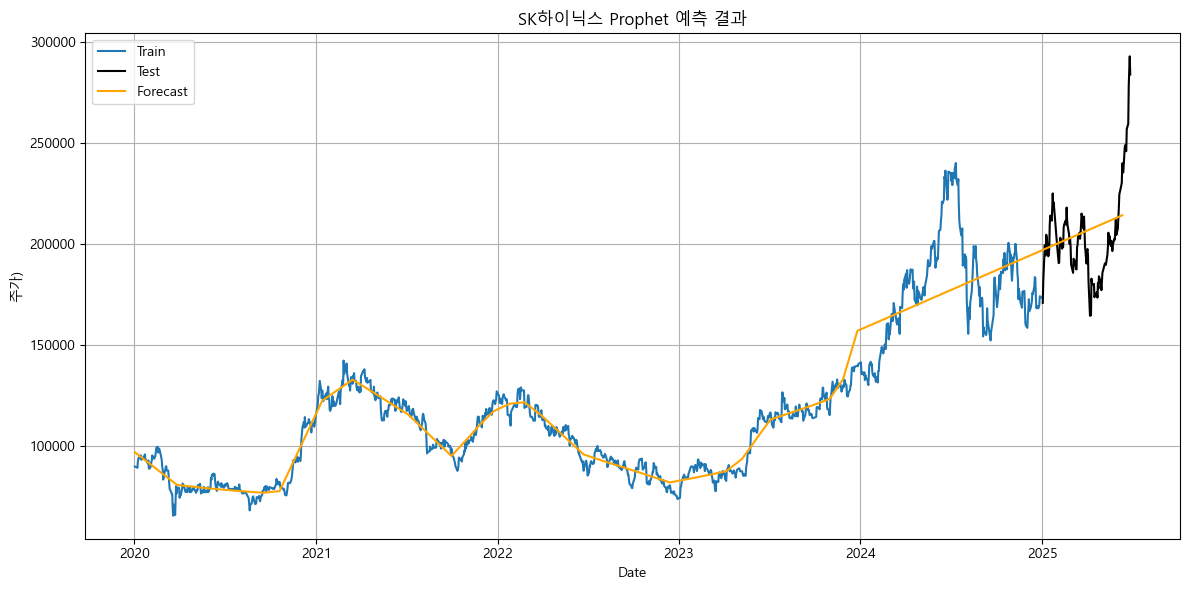

In [4]:
result_df = pd.DataFrame(results)
best = result_df.sort_values(by='MAE').reset_index(drop=True)
print(best.head(1))

best_params = best.iloc[0]
final_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    changepoint_range=best_params['changepoint_range'],
    n_changepoints=best_params['n_changepoints'],
    yearly_seasonality=best_params['yearly'],
    weekly_seasonality=best_params['weekly'],
    daily_seasonality=best_params['daily']
)
final_model.fit(train)

future = final_model.make_future_dataframe(periods=len(test), freq='B')
forecast = final_model.predict(future)

plt.rcParams['font.family'] = "Malgun Gothic"
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test', color='black')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')
plt.title("SK하이닉스 Prophet 예측 결과")
plt.xlabel("Date")
plt.ylabel("주가)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()